In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from dataloader import SaliconCoCoDataset

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]

# plt.rc('axes.spines',top=False,bottom=False,left=False,right=False);
# plt.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
# plt.rc(('xtick','ytick'),color=(1,1,1,0));

# Dataset and model

In [4]:
dataset_folder = "../data/"
txt_path = "./dataset/train_list.txt"
img_list = np.loadtxt(txt_path, dtype=str)
dataset = SaliconCoCoDataset(dataset_folder, img_list)

BATCH_SIZE = 1
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

a = iter(train_loader).next()
print(a['image'].dtype, a['saliency'].dtype, a['mask'].dtype)
print(a['image'].shape, a['saliency'].shape, a['mask'].shape)

    

torch.float32 torch.float32 torch.float32
torch.Size([2, 3, 256, 256]) torch.Size([2, 1, 256, 256]) torch.Size([2, 1, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

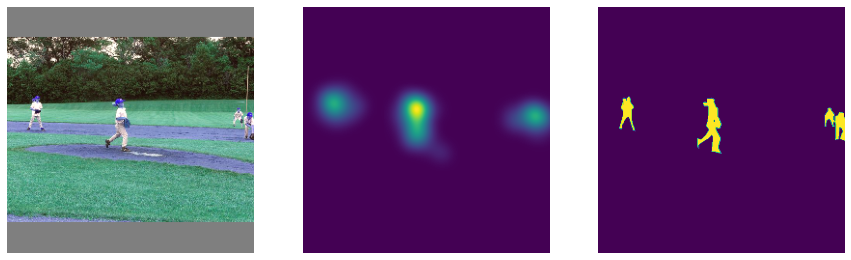

In [5]:
plt.subplot(1,3,1)
plt.imshow(a['image'][0].permute((1,2,0)).numpy()[:,:,::-1]*0.225+0.5)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(a['saliency'][0].permute((1,2,0)).numpy())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(a['mask'][0].permute((1,2,0)).numpy())
plt.axis('off')

# Losses

In [5]:
from model.net import SSNet
from model.loss import loss_sal

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [8]:
model = SSNet(3)

# model_dir = '../basnet_pretrained.pth'
model_dir = '../weights/SSNET_init.pth'
model.load_state_dict(torch.load(model_dir), strict=False)

for name, param in model.named_parameters():
    if "_sal" not in name:
        param.requires_grad = False


In [9]:
# # save weight
# model_dir = "../weights/"
# torch.save(model.state_dict(), model_dir + "SSNET_init.pth")


In [10]:
_ = model(a['image'], segmentation=True)

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [11]:
seg_out, sal_out = model(a['image'], segmentation=False)

In [28]:
from model.loss import multi_seg_loss_fusion
from model.loss import multi_bce_loss_fusion

/usr/local/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [31]:
last_sal_loss, sum_sal_loss = multi_bce_loss_fusion(sal_out[0], sal_out[1],sal_out[2],sal_out[3],sal_out[4],sal_out[5],sal_out[6], a['saliency'])
print(last_sal_loss, sum_sal_loss)

tensor(2.7762, grad_fn=<AddBackward0>) tensor(18.4224, grad_fn=<AddBackward0>)


In [12]:
for i in range(len(sal_out)):
    loss = loss_sal(sal_out[i].squeeze(), a['saliency'].squeeze())
    print(loss)

tensor(1.5502, grad_fn=<AddBackward0>)
tensor(1.4157, grad_fn=<AddBackward0>)
tensor(1.5293, grad_fn=<AddBackward0>)
tensor(1.4211, grad_fn=<AddBackward0>)
tensor(1.3384, grad_fn=<AddBackward0>)
tensor(1.2873, grad_fn=<AddBackward0>)
tensor(1.3692, grad_fn=<AddBackward0>)


In [13]:
loss.backward()

# Inference and Postprocessing

In [120]:
# each peak, map to a countour in segmentaion
# Peak with countour, peak + obj_bb
# Peak w/o countour , peak + pt_bb

# Boundary Awared Crop
# peak + bounding box: center from peak, adjust according to boundary
# peak : center from peak

## Score
# sal score: bb * sal map (sum of pixel ?, )
# seg score: bb * seg map (sum of pixel ?, pixel percentage ?)

In [121]:
import torch
from model.net import SSNet
from skimage.feature.peak import peak_local_max

In [122]:
# Model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SSNet(3, pretrain_resnet=False)
model_dir = "../weights/SSNET_ss_0.pth"
# model_dir = "../weights/SSNET_ss_best.pth"
model.load_state_dict(torch.load(model_dir, map_location=DEVICE), strict=False)
model.to(DEVICE)
model.eval()
print()

In [76]:
# Data
dataset_folder = "../data/"
txt_path = "./dataset/demo_list.txt"
img_list = np.loadtxt(txt_path, dtype=str)[2:]
dataset = SaliconCoCoDataset(dataset_folder, img_list, infer_mode=True)

BATCH_SIZE = 1
val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)    

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


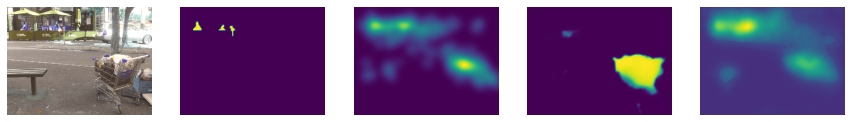

In [77]:
# Predict

i = 0
with torch.no_grad():
    for data in val_loader:
        input_img, sal_map, seg_map = data['image'], data['saliency'], data['mask']
        input_img, sal_map, seg_map = input_img.to(DEVICE), sal_map.squeeze(1).to(DEVICE), seg_map.to(DEVICE)

        seg_out, sal_out = model(input_img)

        plt.subplot(5,5,i*5+1)
        plt.imshow(input_img[0].permute((1,2,0)).cpu().detach().numpy()[:,:,::-1]*0.225+0.5)
        plt.axis('off')

        plt.subplot(5,5,i*5+2)
        plt.imshow(seg_map[0,0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(5,5,i*5+3)
        plt.imshow(sal_map[0].cpu().detach().numpy())
        plt.axis('off')


        plt.subplot(5,5,i*5+4)
        plt.imshow(seg_out[0][0,0].cpu().detach().numpy())
        plt.axis('off')
        plt.subplot(5,5,i*5+5)
        plt.imshow(1 - sal_out[0][0,0].cpu().detach().numpy())
        plt.axis('off')

        i+=1
        if i == 1:
            break

In [12]:
import cv2
def thresh(img):
    th, thresh_binary = cv2.threshold(img, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((5,5),np.uint8)
    thresh_mask = cv2.erode(thresh_binary,kernel,iterations = 2)
    thresh_mask = cv2.dilate(thresh_mask,kernel,iterations = 2)
    return thresh_mask

def mask_to_uint8(img):
    if img.max() < 1:
        img = img*255
    return img.astype(np.uint8)

In [23]:
seg = seg_out[0][0,0].cpu().detach().numpy()
sal_raw = 1 - sal_out[0][0,0].cpu().detach().numpy()

seg = mask_to_uint8(seg)
sal = mask_to_uint8(sal_raw)

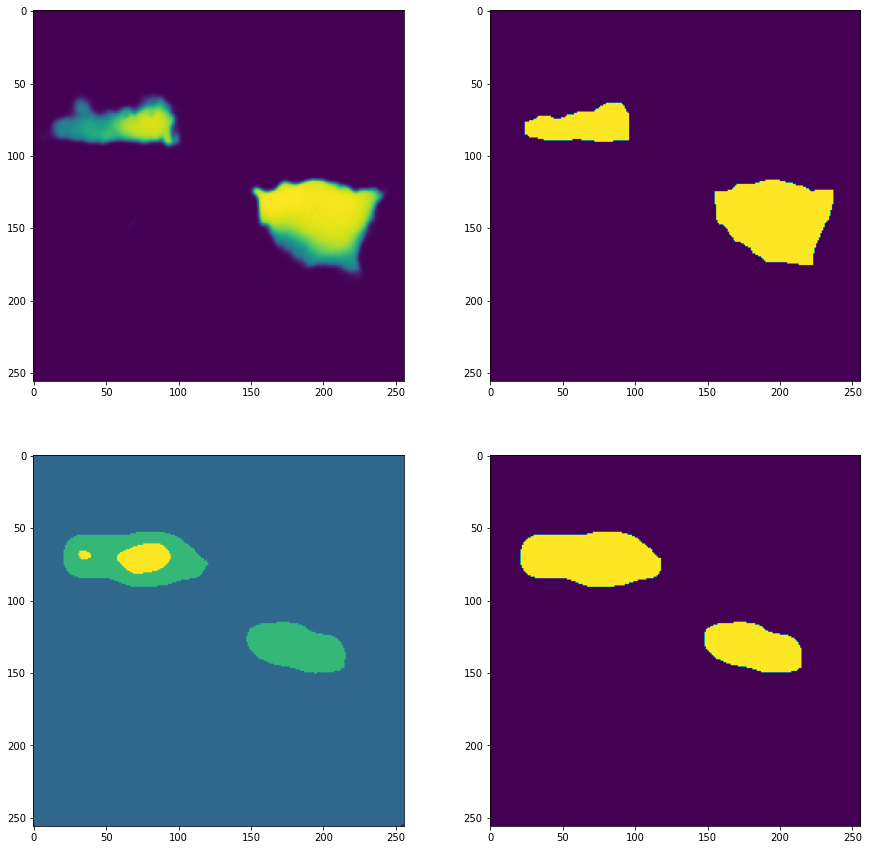

In [24]:

plt.subplot(2,2,1)
plt.imshow(seg)
plt.subplot(2,2,2)
plt.imshow(thresh(seg))

plt.subplot(2,2,3)
plt.imshow(sal)
plt.subplot(2,2,4)
plt.imshow(thresh(sal))

countourt_mask

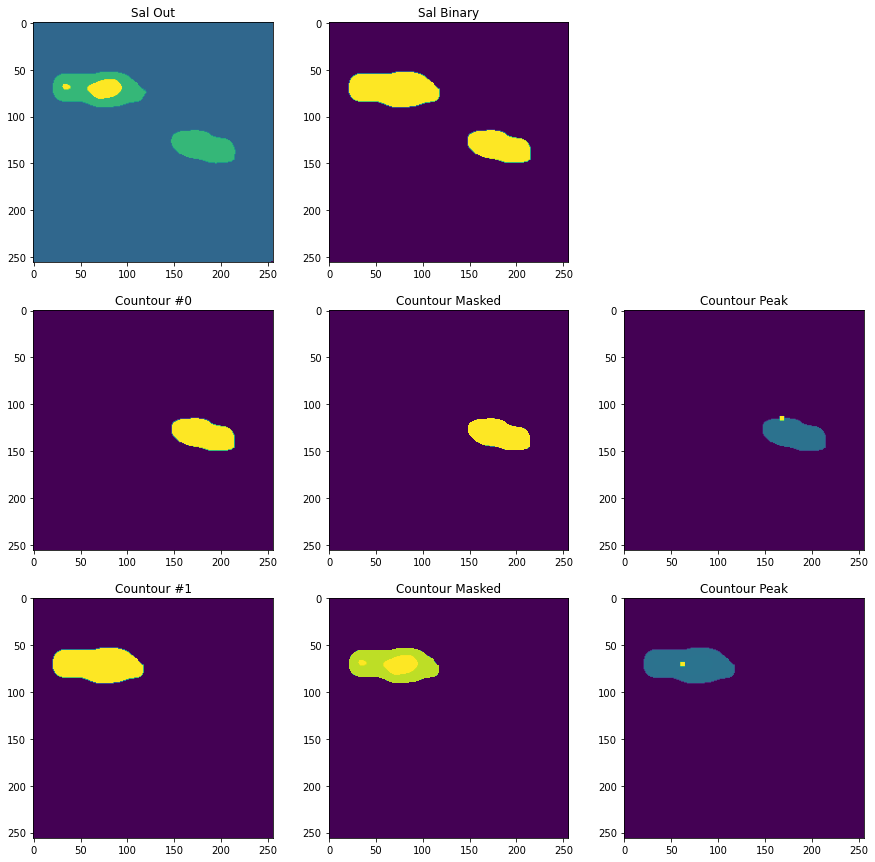

In [25]:
sal_binary = thresh(sal)
contours, hierarchy = cv2.findContours(sal_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
count = len(contours) + 1

plt.subplot(count,3,1)
plt.imshow(sal)
plt.title("Sal Out")

plt.subplot(count,3,2)
plt.imshow(sal_binary)
plt.title("Sal Binary")


i = 4
for c in range(len(contours)):
    mask = np.zeros_like(sal_binary)
    contour_mask = cv2.drawContours(mask, contours, c, 255, -1)
    plt.subplot(count,3,i)
    i += 1
    plt.imshow(contour_mask)
    plt.title(f"Countour #{c}")

    fixation = cv2.bitwise_and(sal, sal, mask=contour_mask)
    plt.subplot(count,3,i)
    i += 1
    plt.imshow(fixation, vmin=min(100, fixation.max()-10))
    plt.title(f"Countour Masked")

    max_indexes = peak_local_max(fixation, num_peaks=1)
    for m in max_indexes:
        x,y = m[0], m[1]
        fixation[x-2:x+3,y-2:y+3] = 255
    plt.subplot(count,3,i)
    i += 1
    plt.imshow(fixation)
    plt.title(f"Countour Peak")

In [26]:
def saliency2peaks(sal_input):
    '''
    Saliency -> thresh -> binary
    binray -> find Countour
    Each Countour -> Countour Mask -> Find Peak
    return peaks
    '''
    peaks = []
    sal_binary = thresh(sal)
    contours, hierarchy = cv2.findContours(sal_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in range(len(contours)):
        mask = np.zeros_like(sal_binary)
        contour_mask = cv2.drawContours(mask, contours, c, 255, -1)
        fixation = cv2.bitwise_and(sal, sal, mask=contour_mask)
        peak = peak_local_max(fixation, num_peaks=1)
        if len(peak) > 0:
            peaks.append(peak[0])

    return np.array(peaks, dtype=np.uint8)

In [27]:
def get_peaksBB(peaks, seg):
    seg_contours, _ = cv2.findContours(thresh(seg), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    peaks_map = {}
    for p in peaks:
        points = np.array([[ [ p[1], p[0]] ]])
        for c in seg_contours:
            dist = cv2.pointPolygonTest(c, (p[1], p[0]), measureDist=True)
            # store all point with dist > -10, include the peak -> get the bounding box
            if dist > -10:
                points = np.vstack([points,c])
        if len(points) == 1: ## single point
            rect = (p[1], p[0], 1, 1)
        else:
            rect = cv2.boundingRect(points)
        peaks_map[(p[1],p[0])] = rect
    return peaks_map


In [28]:
def visualize_peak_bb(peak_map, seg):
    cm = plt.get_cmap()
    seg_img = (cm(seg)[:,:,:3]* 255).astype(np.uint8)

    for peak, rect in peak_map.items():
        py, px = peak[0], peak[1]
        seg_img[px-2:px+3, py-2:py+3, 0] = 255
        seg_img[px-2:px+3, py-2:py+3, 1] = 0
        seg_img[px-2:px+3, py-2:py+3, 2] = 0
        x,y,w,h = rect
        seg_img = cv2.rectangle(seg_img,(x,y),(x+w,y+h),(0,255,0),2)
    plt.imshow(seg_img)

In [29]:
peaks = saliency2peaks(sal)
peaks_bb = get_peaksBB(peaks, seg)

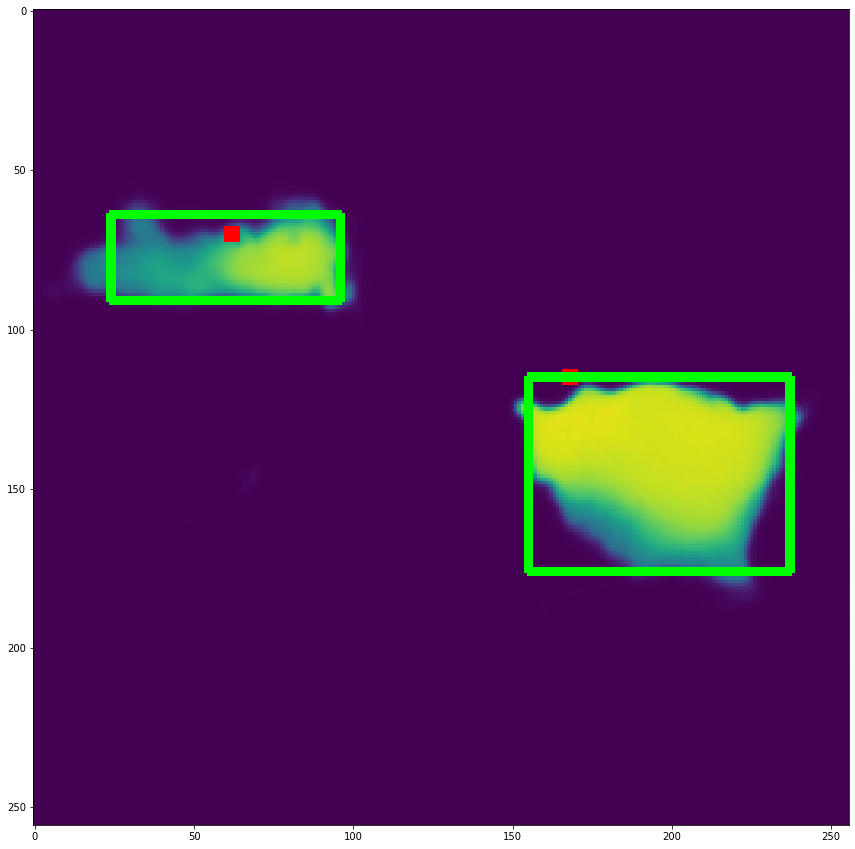

In [30]:
visualize_peak_bb(peaks_bb, seg)

In [31]:
print(peaks_bb)

{(168, 115): (155, 115, 82, 61), (62, 70): (24, 64, 72, 27)}


In [44]:
def bb2xyxy(bb):
    x,y,w,h = bb
    return x, y, x+w, y+h

def refine_saliency_awared_xyxy(center, bb, target_size):
    cen_x, cen_y = center
    x1,y1,x2,y2 = bb2xyxy(bb)
    tar_x, tar_y = target_size

    fill_x1 = min(cen_x - x1, tar_x//2)
    remainder_x = tar_x - fill_x1
    fill_x2 = min(x2 - cen_x, remainder_x)
    remainder_x -= fill_x2
    if remainder_x > 0:
        fill_x1 += remainder_x//2
        fill_x2 += (remainder_x+1)//2

    fill_y1 = min(cen_y - y1, tar_y//2)
    remainder_y = tar_y - fill_y1
    fill_y2 = min(y2 - cen_y, remainder_y)
    remainder_y -= fill_y2
    if remainder_y > 0:
        fill_y1 += remainder_y//2
        fill_y2 += (remainder_y+1)//2

    return cen_x-fill_x1, cen_y-fill_y1, cen_x+fill_x2, cen_y+fill_y2

def refine_boundary_aware_xyxy(xyxy, max_size):
    x1,y1,x2,y2 = xyxy
    w, h = max_size
    diff_x = x2-w
    if diff_x > 0:
        x2 -= diff_x
        x1 -= diff_x
        x1 = max(0, x1)

    diff_y = y2-h
    if diff_y > 0:
        y2 -= diff_y
        y1 -= diff_y
        y1 = max(0, y1)
    return x1,y1,x2,y2


def get_target_bb(peaks_bb, target_size, max_size=(256,256)):
    rects = []
    for (peak, bb) in peaks_bb.items():
        xyxy = refine_saliency_awared_xyxy(peak,bb,target_size)
        xyxy = refine_boundary_aware_xyxy(xyxy, max_size)
        rects.append(xyxy)
    return list(set(rects))

target_size = (100, 50)
candidate_xyxy = get_target_bb(peaks_bb, target_size)

In [42]:
def normalize_salmap(mat):
    mat = mat - mat.min()
    mat = mat / mat.max()
    return mat 

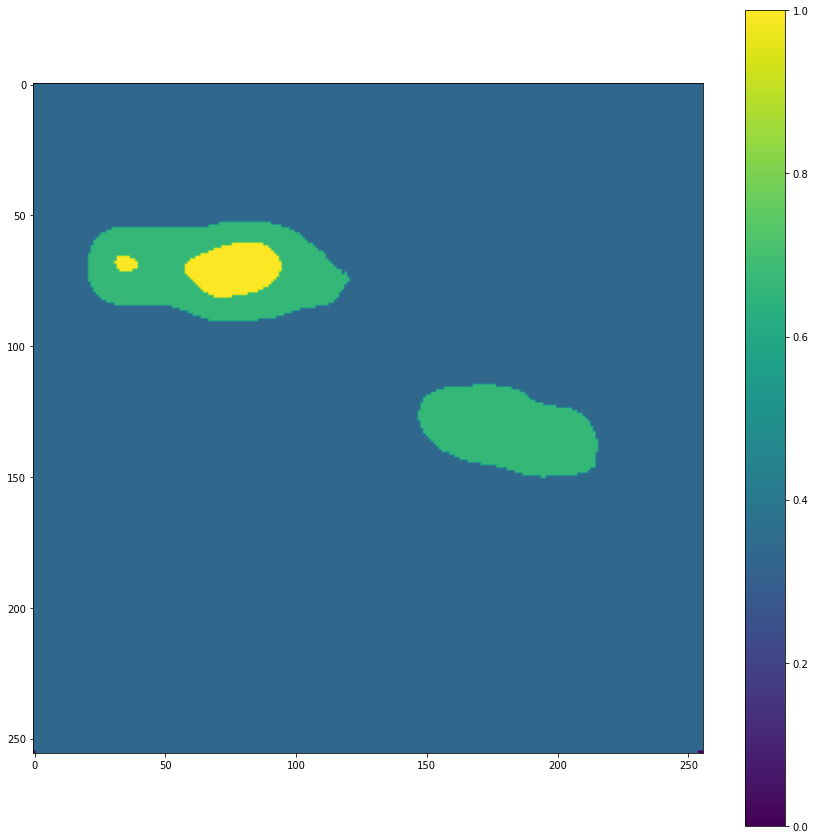

In [43]:
sal_norm = normalize_salmap(sal)
plt.imshow(sal_norm)
plt.colorbar()

In [72]:
def rank_xyxy(candidate_xyxy, sal, seg):
    sal_norm = normalize_salmap(sal)
    scores_xyxy = []
    for xyxy in candidate_xyxy:
        x1,y1,x2,y2 = xyxy
        area = (y2-y1)*(x2-x1)

        sal_partial = sal_norm[y1:y2, x1:x2]
        score_sal = sal_partial.sum() / area

        seg_partial = seg[y1:y2, x1:x2]
        score_seg = seg_partial.sum() / area
        
        total = score_sal * score_seg
        scores_xyxy.append([total, xyxy])
    return sorted(scores_xyxy, reverse=True)

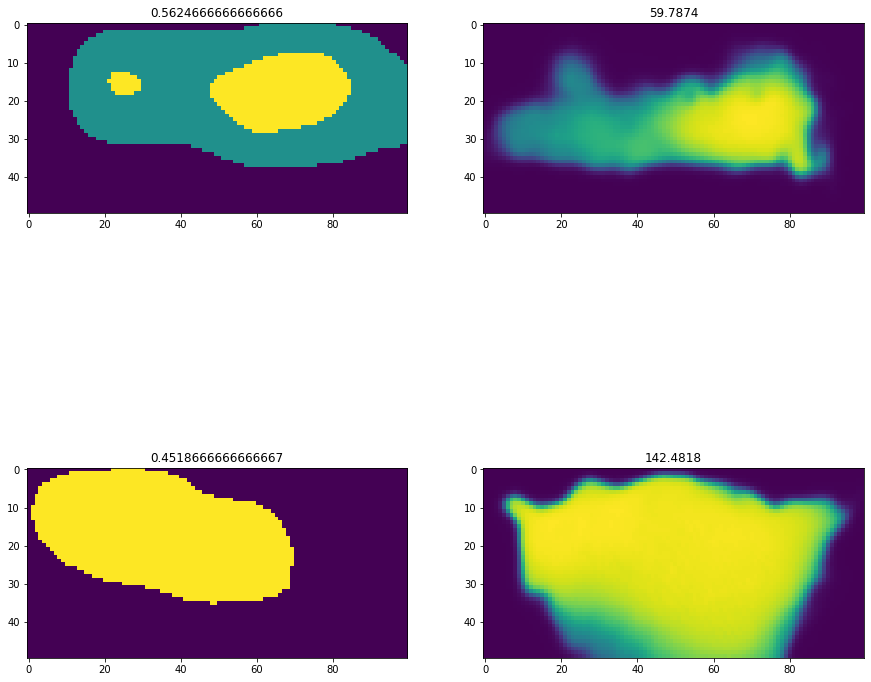

In [56]:
scores = {}
i = 0
for xyxy in candidate_xyxy:
    i+=1
    x1,y1,x2,y2 = xyxy
    area = (y2-y1)*(x2-x1)

    sal_partial = sal_norm[y1:y2, x1:x2]
    score_sal = sal_partial.sum() / area
    plt.subplot(2,2,i)
    plt.imshow(sal_partial)
    plt.title(f"{score_sal}")

    i+=1
    seg_partial = seg[y1:y2, x1:x2]
    score_seg = seg_partial.sum() / area
    plt.subplot(2,2,i)
    plt.imshow(seg_partial)
    plt.title(f"{score_seg}")

    total = score_sal * score_seg
    scores[xyxy] = total

In [73]:
scores_xyxy = rank_xyxy(candidate_xyxy, sal, seg)
scores_xyxy

[[64.38277602666666, (146, 115, 246, 165)],
 [33.62841958666666, (10, 53, 110, 103)]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


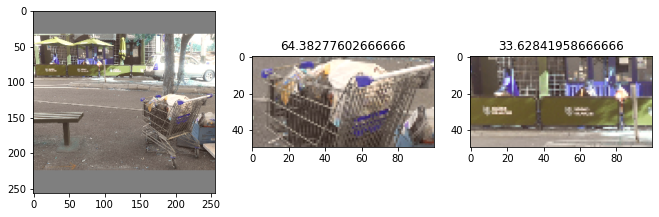

In [75]:
# visualize candidate with score
img = input_img[0].permute((1,2,0)).cpu().detach().numpy()[:,:,::-1]*0.225+0.5
plt.subplot(1,4,1)
plt.imshow(img)

for i, (score,xyxy) in enumerate(scores_xyxy):
    plt.subplot(1,4,i+2)
    x1,y1,x2,y2 = xyxy
    plt.imshow(img[y1:y2, x1:x2])
    plt.title(score)    

# Inference and Postprocessing - Deployment

In [10]:
from deploy import loadModel, predict_crop, toSalSegBase64, crop
from PIL import Image
from image_helper import *
from model.net import SSNet

In [5]:
torch.set_flush_denormal(True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_dir = "../weights/SSNET_best.pth"
model_dir = "../weights/SSNET_ss_0.pth"
model = loadModel(model_dir, DEVICE)

/usr/local/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


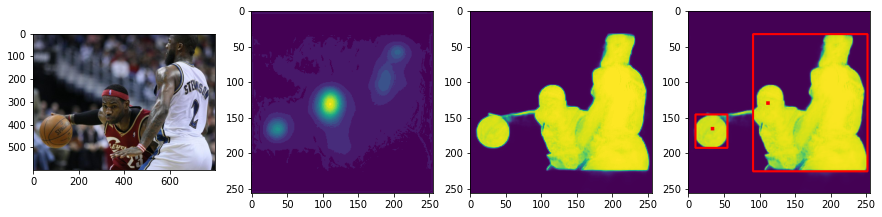

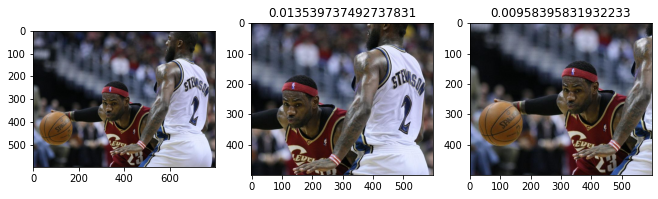

In [60]:
# img_path = "/Users/ckh/Downloads/cat.jpeg"
img_path = "/Users/ckh/Desktop/清华TsingHua/Inmagine/data/sample/6.jpeg"
img = np.array(Image.open(img_path).convert('RGB'))
# img_tensor = image2tensor(img)
crop_size = (600,550)

scores_xyxy, peaks_bb, seg, sal = predict_crop(model, img, crop_size)

# plt.subplot(1,4,1)
# plt.imshow(img)
# plt.subplot(1,4,2)
# plt.imshow(sal)
# plt.subplot(1,4,3)
# plt.imshow(seg)
# plt.subplot(1,4,4)
# visualize_peak_bb(peaks_bb, seg)
plt.figure()
visualize_prediction(img, sal, seg, peaks_bb)

plt.figure()
visualize_crop_result(scores_xyxy, img)

In [67]:
img_size, target_size, feat_size, peaks_bb

((800, 600),
 (192, 160),
 (256, 256),
 {(34, 165): (10, 145, 45, 47), (112, 129): (91, 32, 161, 193)})

In [62]:
get_candidate_bb(peaks_bb, target_size, img_size, feat_size)

[(0, 64, 192, 224), (64, 49, 256, 209)]

In [69]:
## Combined Peaks
peaks_bb_list = list(peaks_bb)
peaks_bb_list, len(peaks_bb_list)

([(34, 165), (112, 129)], 2)

In [81]:
## max 3 peaks
peaks_count = len(peaks_bb_list)
merge_peaks_bb = {}
for a in range(0, peaks_count):
    for b in range(a+1, peaks_count):
        # print("TWO", a,b)
        p1 = peaks_bb_list[a] 
        p2 = peaks_bb_list[b]
        key2 = merge_pt(p1,p2)
        bb2 = merge_bb(peaks_bb[p1],peaks_bb[p2])
        merge_peaks_bb[key2] = bb2
        for c in range(b+1, peaks_count):
            # print("THREE", a,b,c)
            p3 = peaks_bb_list[c]
            key3 = merge_pt3(p1,p2, p3)
            bb3 = merge_bb(bb2, peak_bb[p3])
            merge_peaks_bb[key3] = bb3

In [80]:
def merge_bb(bb1, bb2):
    a1,b1,c1,d1 = bb1
    a2,b2,c2,d2 = bb2
    a = min(a1,a2)
    b = min(b1,b2)
    c = max(c1,c2)
    d = max(d1,d2)
    return (a,b,c,d)

def merge_pt(pt1, pt2):
    x = (pt1[0] + pt2[0])//2
    y = (pt1[1] + pt2[1])//2
    return (x,y)

def merge_pt3(pt1, pt2, pt3):
    x = (pt1[0] + pt2[0] + pt3[0])//2
    y = (pt1[1] + pt2[1] + pt3[0])//2
    return (x,y)

In [84]:
bb2, target_size

((10, 32, 161, 193), (192, 160))

In [85]:
bb2[2] - bb2[0], bb2[3] - bb2[1]

(151, 161)

In [94]:
within_size(bb2, target_size)

True

In [93]:
def within_size(bb, target_size):
    w = bb[2] - bb[0] 
    h = bb[3] - bb[1]
    return w <= target_size[0] and h <= target_size[1]

    